<a href="https://colab.research.google.com/github/zhou1126/Marquette_teaching_finance/blob/main/class2_Taiwan_bankruptcy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
fedesoriano_company_bankruptcy_prediction_path = kagglehub.dataset_download('fedesoriano/company-bankruptcy-prediction')

print('Data source import complete.')


100%|██████████| 4.63M/4.63M [00:00<00:00, 59.5MB/s]

Extracting files...


Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/root/.cache/kagglehub/datasets/fedesoriano/company-bankruptcy-prediction/versions/2'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import matplotlib.pyplot as plt

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/root/.cache/kagglehub/datasets/fedesoriano/company-bankruptcy-prediction/versions/2/data.csv


In [3]:
fedesoriano_company_bankruptcy_prediction_path

'/root/.cache/kagglehub/datasets/fedesoriano/company-bankruptcy-prediction/versions/2'

In [4]:
df = pd.read_csv('/root/.cache/kagglehub/datasets/fedesoriano/company-bankruptcy-prediction/versions/2/data.csv')
# Remove leading and trailing spaces from column names
df.columns = df.columns.str.strip()
df.head()

# Profitability: Operating Gross Margin
# Liquidity: Current Ratio
# Leverage: 'Total debt/Total net worth'
# Efficiency: 'Total Asset Turnover'
# Cash flow: 'Cash Flow to Total Assets'
# Growth: 'Operating Profit Growth Rate'

df = df[['Bankrupt?', 'Operating Gross Margin', 'Current Ratio', 'Total debt/Total net worth', 'Total Asset Turnover', 'Cash Flow to Total Assets', 'Operating Profit Growth Rate']]
df = df.dropna()
print(f'df has {df.shape[0]} rows')


percentile_10 = df[['Operating Gross Margin', 'Current Ratio', 'Total debt/Total net worth', 'Total Asset Turnover', 'Cash Flow to Total Assets', 'Operating Profit Growth Rate']].quantile(0.1)
percentile_90 = df[['Operating Gross Margin', 'Current Ratio', 'Total debt/Total net worth', 'Total Asset Turnover', 'Cash Flow to Total Assets', 'Operating Profit Growth Rate']].quantile(0.9)

# Filter data to keep values within 10th and 90th percentiles for each column
filtered_df = df[
    (df[['Operating Gross Margin', 'Current Ratio', 'Total debt/Total net worth', 'Total Asset Turnover', 'Cash Flow to Total Assets', 'Operating Profit Growth Rate']] >= percentile_10).all(axis=1) &
    (df[['Operating Gross Margin', 'Current Ratio', 'Total debt/Total net worth', 'Total Asset Turnover', 'Cash Flow to Total Assets', 'Operating Profit Growth Rate']] <= percentile_90).all(axis=1)
]

print(f'filtered_df has {filtered_df.shape[0]} rows')


df has 6819 rows
filtered_df has 2497 rows


In [5]:
filtered_df.head()

,Bankrupt?,Operating Gross Margin,Current Ratio,Total debt/Total net worth,Total Asset Turnover,Cash Flow to Total Assets,Operating Profit Growth Rate
1,1,0.610235,0.006016,0.012502,0.064468,0.641100,0.848088
4,1,0.598783,0.006022,0.005150,0.175412,0.622374,0.848258
7,0,0.601738,0.009657,0.005278,0.218891,0.641553,0.848082
8,0,0.603612,0.013499,0.002266,0.154423,0.649869,0.848159
10,0,0.614026,0.006097,0.004933,0.076462,0.642950,0.848238


In [6]:
percentile_10, percentile_90

(Operating Gross Margin          0.596513
 Current Ratio                   0.005750
 Total debt/Total net worth      0.001619
 Total Asset Turnover            0.047976
 Cash Flow to Total Assets       0.609768
 Operating Profit Growth Rate    0.847886
 Name: 0.1, dtype: float64,
 Operating Gross Margin          0.623153
 Current Ratio                   0.027156
 Total debt/Total net worth      0.014992
 Total Asset Turnover            0.254873
 Cash Flow to Total Assets       0.697145
 Operating Profit Growth Rate    0.848285
 Name: 0.9, dtype: float64)

In [7]:
grouped_averages = filtered_df.groupby("Bankrupt?").median()

# Display the grouped averages
grouped_averages.head()

,Operating Gross Margin,Current Ratio,Total debt/Total net worth,Total Asset Turnover,Cash Flow to Total Assets,Operating Profit Growth Rate
Bankrupt?,,,,,,
0,0.606552,0.010519,0.005547,0.125937,0.646075,0.848043
1,0.601904,0.008454,0.010095,0.107946,0.638076,0.847994


from matplotlib import pyplot as plt
_df_0['Operating Gross Margin'].plot(kind='hist', bins=20, title='Operating Gross Margin')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Current Ratio'].plot(kind='hist', bins=20, title='Current Ratio')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Total debt/Total net worth'].plot(kind='hist', bins=20, title='Total debt/Total net worth')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['Total Asset Turnover'].plot(kind='hist', bins=20, title='Total Asset Turnover')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='Operating Gross Margin', y='Current Ratio', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='Current Ratio', y='Total debt/Total net worth', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='Total debt/Total net worth', y='Total Asset Turnover', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='Total Asset Turnover', y='Cash Flow to Total Assets', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Total debt/Total net worth']
  ys = series['Operating Gross Margin']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('Total debt/Total net worth', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Total debt/Total net worth')
_ = plt.ylabel('Operating Gross Margin')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Total debt/Total net worth']
  ys = series['Current Ratio']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('Total debt/Total net worth', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Total debt/Total net worth')
_ = plt.ylabel('Current Ratio')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Total debt/Total net worth']
  ys = series['Total Asset Turnover']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('Total debt/Total net worth', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Total debt/Total net worth')
_ = plt.ylabel('Total Asset Turnover')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Total debt/Total net worth']
  ys = series['Cash Flow to Total Assets']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('Total debt/Total net worth', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Total debt/Total net worth')
_ = plt.ylabel('Cash Flow to Total Assets')

from matplotlib import pyplot as plt
_df_12['Operating Gross Margin'].plot(kind='line', figsize=(8, 4), title='Operating Gross Margin')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['Current Ratio'].plot(kind='line', figsize=(8, 4), title='Current Ratio')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['Total debt/Total net worth'].plot(kind='line', figsize=(8, 4), title='Total debt/Total net worth')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['Total Asset Turnover'].plot(kind='line', figsize=(8, 4), title='Total Asset Turnover')
plt.gca().spines[['top', 'right']].set_visible(False)

In [8]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2497 entries, 1 to 6815
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Bankrupt?                     2497 non-null   int64  
 1   Operating Gross Margin        2497 non-null   float64
 2   Current Ratio                 2497 non-null   float64
 3   Total debt/Total net worth    2497 non-null   float64
 4   Total Asset Turnover          2497 non-null   float64
 5   Cash Flow to Total Assets     2497 non-null   float64
 6   Operating Profit Growth Rate  2497 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 156.1 KB


In [9]:
filtered_df.columns

Index(['Bankrupt?', 'Operating Gross Margin', 'Current Ratio',
       'Total debt/Total net worth', 'Total Asset Turnover',
       'Cash Flow to Total Assets', 'Operating Profit Growth Rate'],
      dtype='object')

# Cluster Analysis

In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

columns_for_clustering = ['Operating Gross Margin', 'Current Ratio', 'Total debt/Total net worth', 'Total Asset Turnover', 'Cash Flow to Total Assets', 'Operating Profit Growth Rate']
X = filtered_df[columns_for_clustering]


In [11]:
X.head()

,Operating Gross Margin,Current Ratio,Total debt/Total net worth,Total Asset Turnover,Cash Flow to Total Assets,Operating Profit Growth Rate
1,0.610235,0.006016,0.012502,0.064468,0.641100,0.848088
4,0.598783,0.006022,0.005150,0.175412,0.622374,0.848258
7,0.601738,0.009657,0.005278,0.218891,0.641553,0.848082
8,0.603612,0.013499,0.002266,0.154423,0.649869,0.848159
10,0.614026,0.006097,0.004933,0.076462,0.642950,0.848238


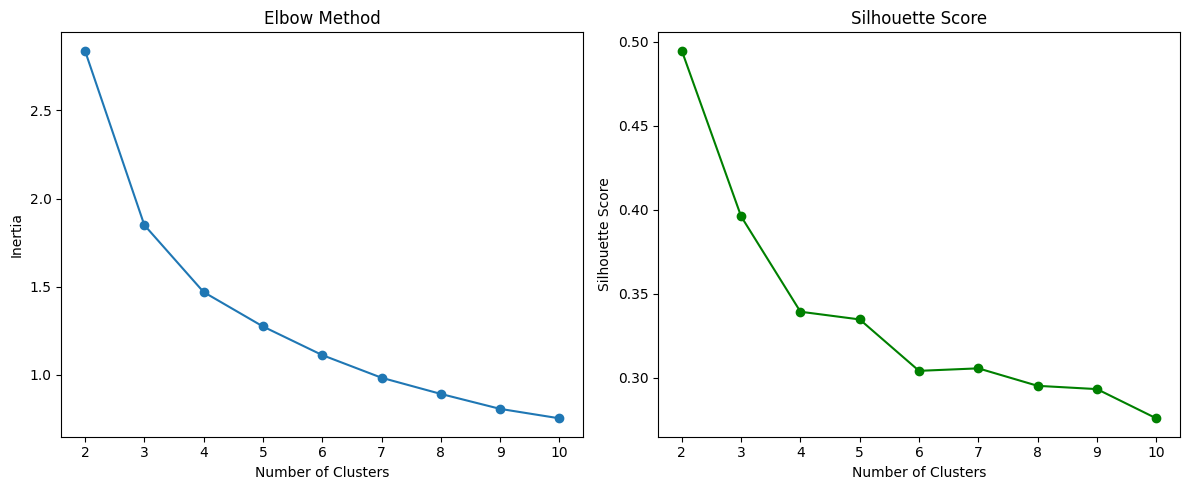

In [12]:
# Elbow Method
inertia = []
silhouette_scores = []
range_n_clusters = range(2, 11)  # Test for 2 to 10 clusters

for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=20).fit(X)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

# Plot Inertia and Silhouette Score
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range_n_clusters, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

plt.subplot(1, 2, 2)
plt.plot(range_n_clusters, silhouette_scores, marker='o', color='green')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

# Elbow Method Plot (Inertia vs. Number of Clusters):
# Look for the "elbow," which is the point where the decrease in inertia slows down significantly. This suggests the optimal number of clusters.

# Silhouette Score Plot (Silhouette Score vs. Number of Clusters):
# The peak value of the Silhouette Score indicates the best number of clusters, as it represents the best separation and compactness of the clusters.

# Looks 6 is a good number of clusters

In [13]:
optimal_clusters = 2

# K-Means Clustering
kmeans = KMeans(n_clusters=optimal_clusters, random_state=20).fit(X)
X['Cluster'] = kmeans.labels_

# Append "Bankrupt?" column to analyze
X['Bankrupt?'] = df['Bankrupt?']

# Analyze each cluster
cluster_analysis = X.groupby('Cluster').mean()
cluster_analysis['Record Count'] = X['Cluster'].value_counts().sort_index()

print("Cluster Analysis (Means and Record Counts):\n", cluster_analysis)

Cluster Analysis (Means and Record Counts):
          Operating Gross Margin  Current Ratio  Total debt/Total net worth  \
Cluster                                                                      
0                      0.608121       0.011366                    0.005906   
1                      0.606303       0.012111                    0.006485   

         Total Asset Turnover  Cash Flow to Total Assets  \
Cluster                                                    
0                    0.098573                   0.647019   
1                    0.184342                   0.649862   

         Operating Profit Growth Rate  Bankrupt?  Record Count  
Cluster                                                         
0                            0.848049   0.011184          1520  
1                            0.848060   0.008188           977  


In [14]:
cluster_analysis

,Operating Gross Margin,Current Ratio,Total debt/Total net worth,Total Asset Turnover,Cash Flow to Total Assets,Operating Profit Growth Rate,Bankrupt?,Record Count
Cluster,,,,,,,,
0,0.608121,0.011366,0.005906,0.098573,0.647019,0.848049,0.011184,1520
1,0.606303,0.012111,0.006485,0.184342,0.649862,0.848060,0.008188,977


In [15]:
cluster_analysis

,Operating Gross Margin,Current Ratio,Total debt/Total net worth,Total Asset Turnover,Cash Flow to Total Assets,Operating Profit Growth Rate,Bankrupt?,Record Count
Cluster,,,,,,,,
0,0.608121,0.011366,0.005906,0.098573,0.647019,0.848049,0.011184,1520
1,0.606303,0.012111,0.006485,0.184342,0.649862,0.848060,0.008188,977


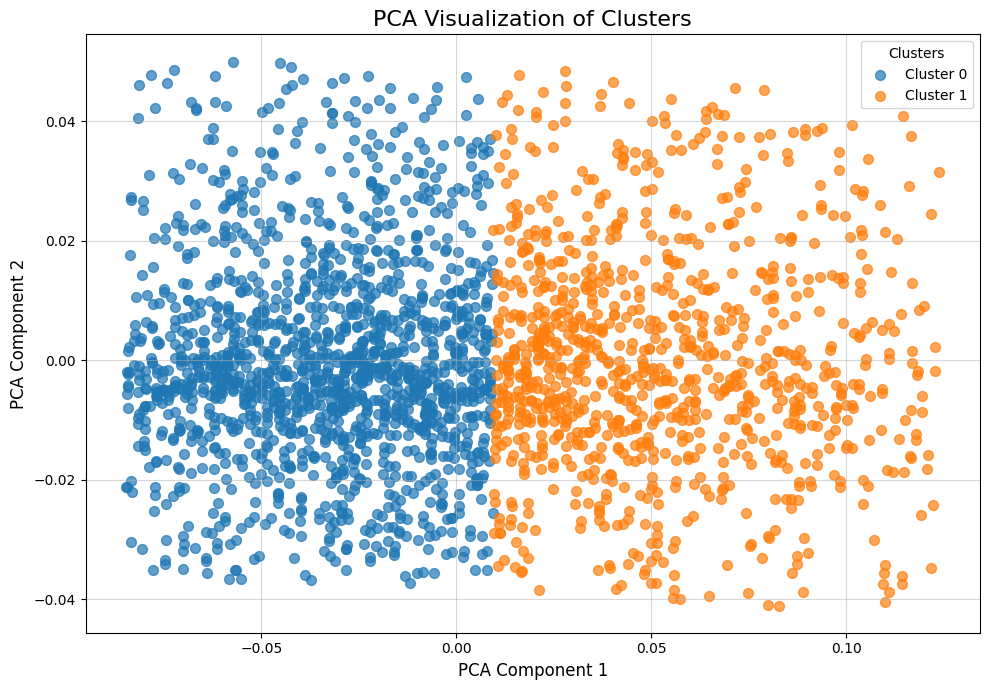

In [16]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Columns to use for PCA
pca_columns = ['Operating Gross Margin', 'Current Ratio', 'Total debt/Total net worth',
               'Total Asset Turnover', 'Cash Flow to Total Assets', 'Operating Profit Growth Rate']

# Perform PCA
pca = PCA(n_components=2, random_state=42)  # Reduce to 2 components for visualization
pca_result = pca.fit_transform(X[pca_columns])

# Add PCA results and cluster labels to the DataFrame
X['PCA1'] = pca_result[:, 0]
X['PCA2'] = pca_result[:, 1]

# Plot the PCA results, colored by cluster
plt.figure(figsize=(10, 7))
for cluster_label in X['Cluster'].unique():
    cluster_data = X[X['Cluster'] == cluster_label]
    plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], label=f'Cluster {cluster_label}', s=50, alpha=0.7)

# Add labels and title
plt.title('PCA Visualization of Clusters', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)
plt.legend(title='Clusters')
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()


In [17]:
X.head()

,Operating Gross Margin,Current Ratio,Total debt/Total net worth,Total Asset Turnover,Cash Flow to Total Assets,Operating Profit Growth Rate,Cluster,Bankrupt?,PCA1,PCA2
1,0.610235,0.006016,0.012502,0.064468,0.641100,0.848088,0,1,-0.067877,-0.005361
4,0.598783,0.006022,0.005150,0.175412,0.622374,0.848258,1,1,0.042661,-0.027463
7,0.601738,0.009657,0.005278,0.218891,0.641553,0.848082,1,0,0.086616,-0.009260
8,0.603612,0.013499,0.002266,0.154423,0.649869,0.848159,1,0,0.022395,0.001101
10,0.614026,0.006097,0.004933,0.076462,0.642950,0.848238,0,0,-0.055967,-0.003609


# Let's see we could predict bancruptcy

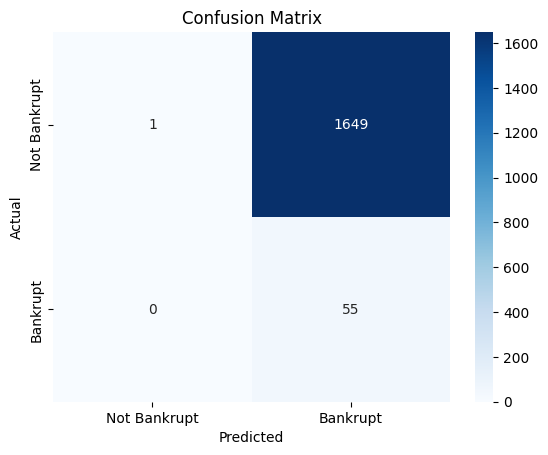

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.00      0.00      1650
           1       0.03      1.00      0.06        55

    accuracy                           0.03      1705
   macro avg       0.52      0.50      0.03      1705
weighted avg       0.97      0.03      0.00      1705

Accuracy: 0.03284457478005865
AUC: 0.8373829201101928


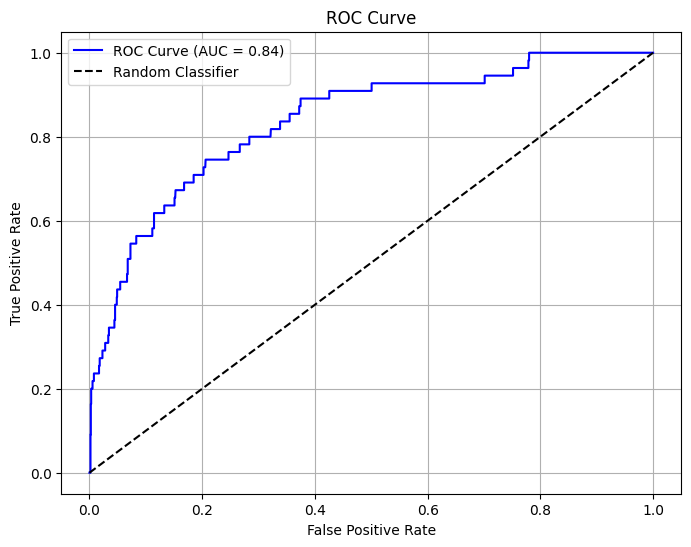

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    accuracy_score
)
import matplotlib.pyplot as plt
import seaborn as sns

selected_features = filtered_df.columns.drop("Bankrupt?")
target = "Bankrupt?"

# Features and target
X = df[selected_features]
y = df[target]

# Split data into training and testing sets (75% training, 25% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Initialize logistic regression model
# log_reg = LogisticRegression()
log_reg = LogisticRegression(class_weight='balanced', random_state=42)


# Train the model
log_reg.fit(X_train, y_train)

# Generate predictions and probabilities
y_pred = log_reg.predict(X_test)
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Bankrupt", "Bankrupt"], yticklabels=["Not Bankrupt", "Bankrupt"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report for precision, recall, F1-score
print("Classification Report:\n", classification_report(y_test, y_pred))

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# AUC (Area Under the Curve)
auc_score = roc_auc_score(y_test, y_pred_prob)
print("AUC:", auc_score)

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})", color="blue")
plt.plot([0, 1], [0, 1], "k--", label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="best")
plt.grid()
plt.show()


In [19]:
# The accuracy is too LOW, let's tweak the model

In [ ]:
col = ' Quick Ratio'

plt.figure(figsize=(10, 6))

# Create the box plot
boxplot = df[df[col]<0.05].boxplot(column=col, by="Bankrupt?", grid=False, showfliers=True, patch_artist=True, widths=0.6)

# Get positions of the boxes
positions = range(1, len(df["Bankrupt?"].unique()) + 1)

# # Add mean points to the box plot
# for i, category in enumerate(sorted(df["Bankrupt?"].unique())):
#     category_values = df[df["Bankrupt?"] == category][col].dropna()
#     mean_value = category_values.mean()

#     # Plot the mean at the corresponding box position
#     plt.scatter(positions[i], mean_value, color='red', zorder=3, label="Mean" if i == 0 else None)

# Customize the plot
plt.title(f"Distribution of {col} by Bankruptcy Status")
plt.suptitle("")  # Remove default 'Boxplot grouped by...' title
plt.xlabel("Bankruptcy Status (0 = No, 1 = Yes)")
plt.ylabel(col)

# Add a legend for the mean
plt.legend(loc="best")

# Show grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

In [ ]:
# List all columns except "Bankrupt?" for comparison
columns_to_compare = [col for col in df.columns if col != "Bankrupt?"]

for col in columns_to_compare[0:]:
    plt.figure(figsize=(10, 6))

    # Create the box plot
    boxplot = df.boxplot(column=col, by="Bankrupt?", grid=False, showfliers=True, patch_artist=True, widths=0.6)

    # Get positions of the boxes
    positions = range(1, len(df["Bankrupt?"].unique()) + 1)

    # Add mean points to the box plot
    for i, category in enumerate(sorted(df["Bankrupt?"].unique())):
        category_values = df[df["Bankrupt?"] == category][col].dropna()
        mean_value = category_values.mean()

        # Plot the mean at the corresponding box position
        plt.scatter(positions[i], mean_value, color='red', zorder=3, label="Mean" if i == 0 else None)

    # Customize the plot
    plt.title(f"Distribution of {col} by Bankruptcy Status")
    plt.suptitle("")  # Remove default 'Boxplot grouped by...' title
    plt.xlabel("Bankruptcy Status (0 = No, 1 = Yes)")
    plt.ylabel(col)

    # Add a legend for the mean
    plt.legend(loc="best")

    # Show grid for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Show the plot
    plt.show()

### Try a Logistic Regression Model

In [ ]:
df.columns

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    accuracy_score
)
import matplotlib.pyplot as plt
import seaborn as sns

# selected_features = [" Current Liability to Current Assets"]
selected_features = df.columns.drop("Bankrupt?")
target = "Bankrupt?"

# Features and target
X = df[selected_features]
y = df[target]

# Split data into training and testing sets (75% training, 25% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Initialize logistic regression model
log_reg = LogisticRegression()

# Train the model
log_reg.fit(X_train, y_train)

# Generate predictions and probabilities
y_pred = log_reg.predict(X_test)
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Bankrupt", "Bankrupt"], yticklabels=["Not Bankrupt", "Bankrupt"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report for precision, recall, F1-score
print("Classification Report:\n", classification_report(y_test, y_pred))

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# AUC (Area Under the Curve)
auc_score = roc_auc_score(y_test, y_pred_prob)
print("AUC:", auc_score)

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})", color="blue")
plt.plot([0, 1], [0, 1], "k--", label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="best")
plt.grid()
plt.show()


In [ ]:
print(df[target].mean())

### Bankrupted companies are too few. The data is biased.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    accuracy_score
)
import matplotlib.pyplot as plt
import seaborn as sns

# selected_features = [" Current Liability to Current Assets"]
selected_features = df.columns.drop("Bankrupt?")
target = "Bankrupt?"

# Features and target
X = df[selected_features]
y = df[target]

# Split data into training and testing sets (75% training, 25% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Initialize logistic regression model
# log_reg = LogisticRegression()
log_reg = LogisticRegression(class_weight='balanced', random_state=42)


# Train the model
log_reg.fit(X_train, y_train)

# Generate predictions and probabilities
y_pred = log_reg.predict(X_test)
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Bankrupt", "Bankrupt"], yticklabels=["Not Bankrupt", "Bankrupt"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report for precision, recall, F1-score
print("Classification Report:\n", classification_report(y_test, y_pred))

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# AUC (Area Under the Curve)
auc_score = roc_auc_score(y_test, y_pred_prob)
print("AUC:", auc_score)

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})", color="blue")
plt.plot([0, 1], [0, 1], "k--", label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="best")
plt.grid()
plt.show()


## Variable Selection

In [ ]:
# Get the absolute values of the coefficients
coefficients = pd.DataFrame(log_reg.coef_[0], X.columns, columns=["Coefficient"])

# Sort by absolute coefficient value
coefficients['abs_coeff'] = coefficients['Coefficient'].abs()
coefficients = coefficients.sort_values(by="abs_coeff", ascending=False)

# Display the most significant features
print(coefficients[['Coefficient', 'abs_coeff']])

In [ ]:
from sklearn.linear_model import LogisticRegressionCV

# Use Logistic Regression with L1 regularization
lasso_log_reg = LogisticRegressionCV(penalty='l1', solver='liblinear', max_iter=1000)
lasso_log_reg.fit(X_train, y_train)

# Get the non-zero coefficients
selected_features_lasso = X.columns[(lasso_log_reg.coef_ != 0).flatten()]
print("Selected Features by Lasso:", selected_features_lasso)